In [1]:

import _init_
from constants import *
from set_path import *
from config import *
from functions import *

# Get temperature

In [2]:
file = '/g/data/jh2/av5889/freshquokka/quokka/extern/grackle_data_files/input/CloudyData_UVB=HM2012.h5'
# file = '/g/data/jh2/av5889/quokka_myrepo/quokka/extern/grackle_data_files/input/CloudyData_UVB=FG2011.h5'
grackle = h5py.File(file)
array = grackle['CoolingRates/Primordial/MMW'][()]
#density(1.e-6, 1.e4), redshift(0,15), temperature(10., 1.e9)
table = array[:,0,:]
table_nH   = np.logspace(-10, 4, array.shape[0])
table_temp = np.logspace(1,  9, array.shape[2])

In [3]:

i=0
bins = 100
egas_arr = np.logspace(-21., -5., bins)
nH_arr   = np.logspace(-6.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))

for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        def func(T):
            mu = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
            return C*mu(T,nH)[0] - T

        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

    
# temperature_table = interpolate.RectBivariateSpline(egas_arr, nH_arr, T)


In [16]:
data_path = os.path.join(scratch, 'sims/DiodeBC/ExtDir+SimpleDiode/16pc/')
# data_path = os.path.join(scratch, 'sims/CheckEqui/1e-4/')

In [17]:
infile   = os.path.join(data_path, 'metal_uniform.in')
dom_min, dom_max, ncells = getdomain(infile)
fac = 1
zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))

In [23]:
f = 'plt44000/'
# f = 'plt200000.old.0940113'
inputfile = os.path.join(data_path, f)
ds   = yt.load(inputfile)
ds.current_time.to('Myr')

yt : [INFO     ] 2024-03-10 12:29:38,974 Parameters: current_time              = 958181957841075.9
yt : [INFO     ] 2024-03-10 12:29:38,975 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-03-10 12:29:38,976 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-03-10 12:29:38,978 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


unyt_quantity(30.36295402, 'Myr')

In [24]:
lev = 0
data = ds.covering_grid(level=lev, left_edge=dom_min, dims=ds.domain_dimensions * fac, num_ghost_zones=0)
timestep = ds.current_time.to('Myr')

rho_gas = np.array(data['gasDensity'])
egas    = np.array(data['gasEnergy'])
eint    = np.array(data['gasInternalEnergy'])
vz = np.array(data['z-GasMomentum'])/rho_gas
vx = np.array(data['x-GasMomentum'])/rho_gas
vy = np.array(data['y-GasMomentum'])/rho_gas

In [25]:
egas0=eint
density = rho_gas
cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
rho0 = density*cloudy_H_mass_fraction/hydrogen_mass_cgs


logrho_arr = np.log10(nH_arr[:-1])
logrho     = np.log10(rho0)
delta_rho  = logrho_arr[1] - logrho_arr[0]
idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

logEgas_arr = np.log10(egas_arr[:-1])
logEgas     = np.log10(egas0)
delta_egas  = logEgas_arr[1] - logEgas_arr[0]
idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

temp = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
           wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
      (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
           wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  

/jobfs/110571618.gadi-pbs/ipykernel_4110310/946821525.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[0].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(rho_gas[:,plane,:]/mp),\
/jobfs/110571618.gadi-pbs/ipykernel_4110310/946821525.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(temp[:,plane,:]),\
/jobfs/110571618.gadi-pbs/ipykernel_4110310/946821525.py:55: MatplotlibDeprecationWa

Text(0.5, 0.5, '30.36')

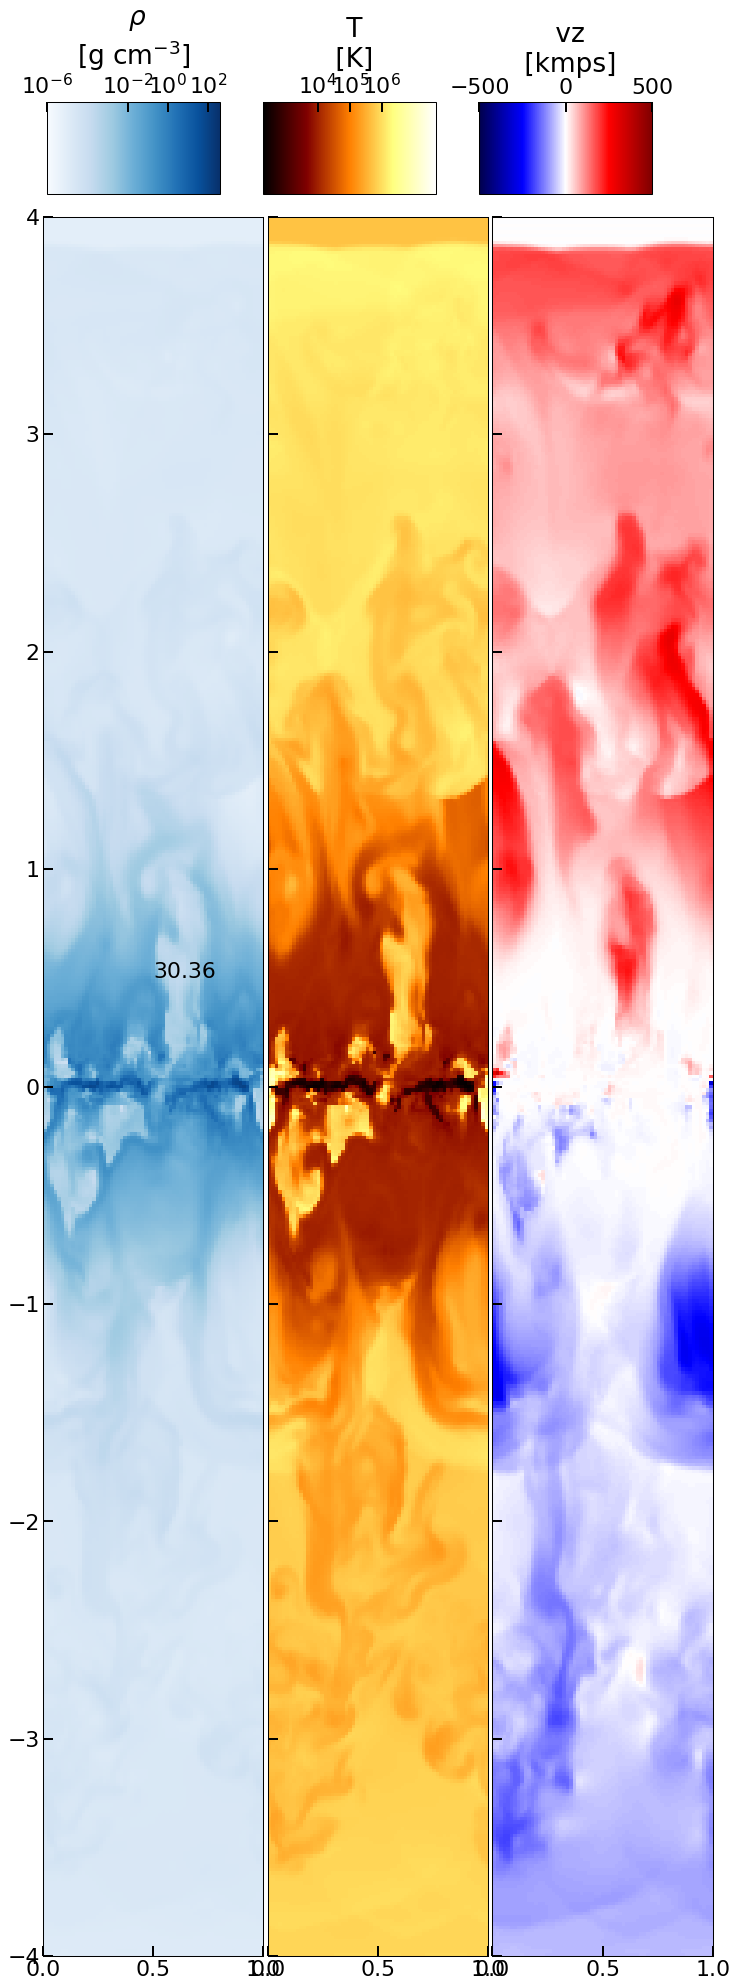

In [26]:
fig, ax = plt.subplots(1, 3, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(12, 32))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.2
dx1 = 0.25
cbtitlex = 0.1
cbtitley = 16.5
plane = (int)(ncells[1]/2)
# plane = 47

plot = ax[0].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(rho_gas[:,plane,:]/mp),\
                    norm=mcolors.LogNorm(vmin=1.e-6, vmax=4.e2),
                    cmap='Blues')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-6,  1.e-2, 1., 1.e2))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")

plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(temp[:,plane,:]),\
                    norm=mcolors.LogNorm(vmin=2.e2, vmax=5.e7),
                    cmap='afmhot')
cax = fig.add_axes([cbarx + dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e2, 1.e4,1.e5, 1.e6,1.e8))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" T" + "\n" + " [K]")
ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)

# plot = ax[0].pcolormesh(yrange/kpc,xrange/kpc, np.transpose(eint[:,:,plane]),\
#                     norm=mcolors.LogNorm(vmin=9.e-16, vmax=5.e-13),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-16, 1.e-15, 1.e-14, 1.e-13))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" eint" )

# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)


# plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(eint[:,plane,:]),\
#                     norm=mcolors.LogNorm(vmin=9.e-21, vmax=5.e-10),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx + 3.*dx1, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-20, 1.e-16, 1.e-10, 1.e-8))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" eint" + "\n" + " [cgs]")
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)

# # ax[1].text(0.5,0.8, "%2.1f"%(ds.current_time.to("Myr")) + ' Myr', transform=ax[1].transAxes, fontsize=12)
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)


plot = ax[2].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(vz[:,plane,:])/kmps,\
                    vmin=-500., vmax=500.,
                    cmap='seismic')
cax = fig.add_axes([cbarx + 2.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-500.,0.0, 500.))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" vz" + "\n" + " [kmps]")
ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
ax[2].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[0].plot(xrange[44]/kpc, yrange[125]/kpc, '*', color='red', markersize=12)
ax[0].text(0.5, 0.5, '%.2f'%(ds.current_time.to('Myr')))
# plt.setp(ax, 'ylim',(0.8,1.))
# plt.setp(ax, 'xlim',(0.2,0.4))
# plt.setp(ax, "ylim", (-4.,-3.))
# ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')
# ax[0].text( 0.4, 0.95, 'Res=%d'%(res) +' pc', transform = ax[0].transAxes, color='black')


/jobfs/110170444.gadi-pbs/ipykernel_4081173/4201693617.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[0].pcolormesh(yrange/kpc,xrange/kpc, np.transpose(temp[:,:,plane]),\
/jobfs/110170444.gadi-pbs/ipykernel_4081173/4201693617.py:65: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[1].pcolormesh(yrange/kpc,xrange/kpc, np.transpose(vz[:,:,plane])/kmps,\


Text(0.5, 0.5, '9.65')

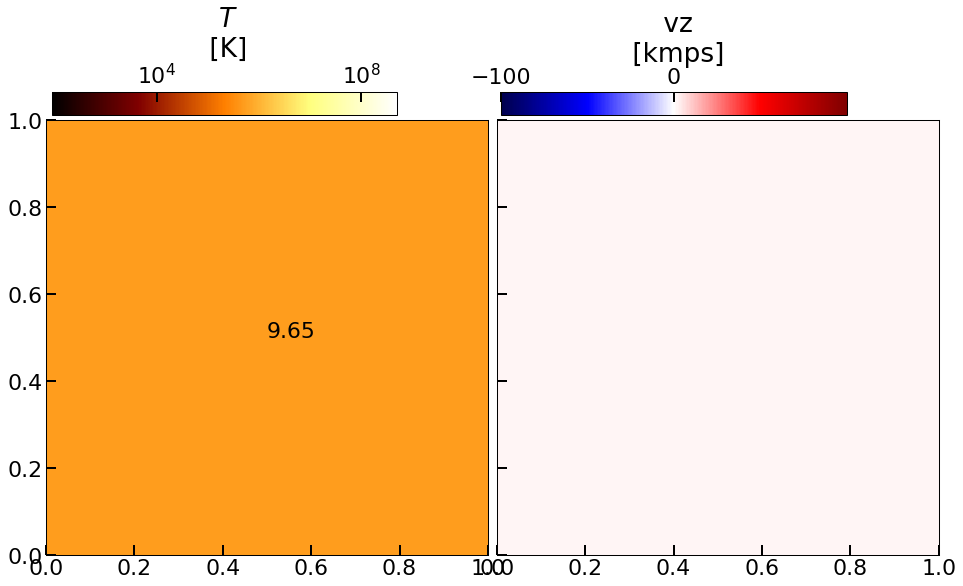

In [38]:
fig, ax = plt.subplots(1, 2, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(16,8))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.3
dx1 = 0.13
cbtitlex = 0.1
cbtitley = 16.5
plane = (int)(ncells[1]/2)
plane = 0

# plot = ax[0].pcolormesh(yrange/kpc,xrange/kpc, np.transpose(rho_gas[:,:,-1]/1.e-24),\
# #                     norm=mcolors.LogNorm(vmin=1.e-28, vmax=4.e-24),
#                     norm=mcolors.LogNorm(vmin=1.e-5, vmax=4.),
#                     cmap='Blues')
# cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-3,  1.e-2,  1.e-1, 1.))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")

plot = ax[0].pcolormesh(yrange/kpc,xrange/kpc, np.transpose(temp[:,:,plane]),\
                    norm=mcolors.LogNorm(vmin=9.e1, vmax=5.e8),
                    cmap='afmhot')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(10, 1.e4, 1.e8))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $T$" + "\n" + r" [K]")


# plot = ax[0].pcolormesh(yrange/kpc,xrange/kpc, np.transpose(diff/1.e-9),\
#                     vmin=-1, vmax=1,
#                     cmap='seismic')
# cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-1, 0., 1.))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" $\Delta \rho$" + "\n" + r" [$\times 10^{-9}$ m$_p$]")
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)

# plot = ax[0].pcolormesh(yrange/kpc,xrange/kpc, np.transpose(eint[:,:,plane]),\
#                     norm=mcolors.LogNorm(vmin=9.e-16, vmax=5.e-13),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-16, 1.e-15, 1.e-14, 1.e-13))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" eint" )

# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)


# plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(egas[:,plane,:]),\
#                     norm=mcolors.LogNorm(vmin=9.e-21, vmax=5.e-8),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx + 3.*dx1, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-20, 1.e-16, 1.e-10, 1.e-8))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" T" + "\n" + " [K]")
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)

# ax[1].text(0.5,0.8, "%2.1f"%(ds.current_time.to("Myr")) + ' Myr', transform=ax[1].transAxes, fontsize=12)
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)


plot = ax[1].pcolormesh(yrange/kpc,xrange/kpc, np.transpose(vz[:,:,plane])/kmps,\
                    vmin=-100., vmax=100.,
                    cmap='seismic')
cax = fig.add_axes([cbarx + 3.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-100., 0.0))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" vz" + "\n" + " [kmps]")
ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[0].plot(xrange[88]/kpc, yrange[39]/kpc, '*', color='red', markersize=12)
ax[0].text(0.5, 0.5, '%.2f'%(ds.current_time.to('Myr')))
# plt.setp(ax, 'ylim',(0.8,1.))
# plt.setp(ax, 'xlim',(0.2,0.4))

# ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')
# ax[0].text( 0.4, 0.95, 'Res=%d'%(res) +' pc', transform = ax[0].transAxes, color='black')x

In [26]:
vz_xy = vz[32,32,0]
np.where(vz_xy>0.)

(array([], dtype=int64),)

In [22]:
 bins = 201

(dlow, dhigh)   = (1.e-6, 1.e2)
(tlow, thigh)   = (10., 2.e10)
dedges = np.logspace(np.log10(dlow), np.log10(dhigh), bins)
tedges = np.logspace(np.log10(tlow), np.log10(thigh), bins)

In [23]:
dx = xrange[1]-xrange[0]
dy = yrange[1]-yrange[0]
dz = zrange[1]-zrange[0]
dV = dx * dy * dz
mass = rho_gas*dV
nH = rho_gas/hydrogen_mass_cgs
htot, dens_bins, temp_bins = np.histogram2d(nH.reshape(-1,1)[:,0], temp.reshape(-1,1)[:,0], \
                                    bins=[dedges, tedges], weights=mass.reshape(-1,1)[:,0])

zout = (np.abs(zrange)>kpc)
nHout =  nH[:,:, zout]
tempOut = temp[:,:,zout]
massOut = mass[:,:,zout]
hout, dens_bins, temp_bins = np.histogram2d(nHout.reshape(-1,1)[:,0], tempOut.reshape(-1,1)[:,0], \
                                    bins=[dedges, tedges], weights=massOut.reshape(-1,1)[:,0])

/jobfs/110170444.gadi-pbs/ipykernel_4081173/2424860769.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[0].pcolormesh(dens_bins[:-1], temp_bins[:-1] , np.transpose(htot-hout)/Msun,\
/jobfs/110170444.gadi-pbs/ipykernel_4081173/2424860769.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[1].pcolormesh(dens_bins[:-1], temp_bins[:-1] , np.transpose(hout)/Msun,\


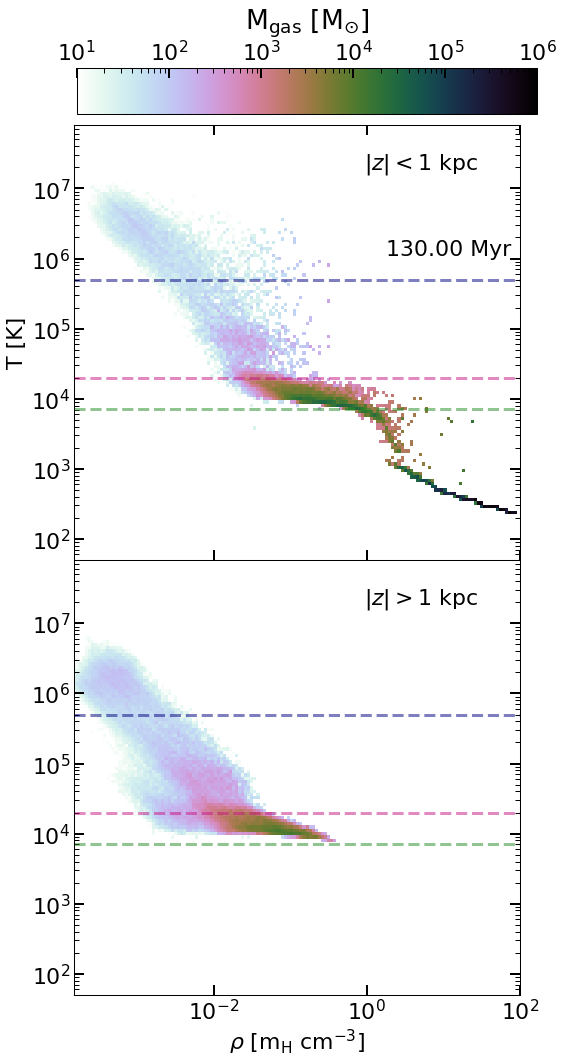

In [24]:
fig, ax = plt.subplots(2, 1, gridspec_kw = {'wspace':0.00, 'hspace':0.00},figsize=(8,16))

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.8
dx1 = 0.13
cbtitlex = 0.1
cbtitley = 16.5

plot = ax[0].pcolormesh(dens_bins[:-1], temp_bins[:-1] , np.transpose(htot-hout)/Msun,\
                     norm=mcolors.LogNorm(vmin=10., vmax=1.e6),cmap='cubehelix_r')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(10., 1.e2, 1.e3, 1.e4, 1.e5, 1.e6))
cax.xaxis.set_ticks_position('top')
cax.set_title(r'M$_{\rm gas}$ [M$_{\odot}$]')


plot = ax[1].pcolormesh(dens_bins[:-1], temp_bins[:-1] , np.transpose(hout)/Msun,\
                     norm=mcolors.LogNorm(vmin=10., vmax=1.e6),cmap='cubehelix_r')


plt.setp(ax, 'yscale', ('log'))
plt.setp(ax, 'xscale', ('log'))
plt.setp(ax, 'xlim',(1.e-4, 1.e2))
plt.setp(ax, 'xlim',(1.5e-4, 1.e2))
plt.setp(ax, 'ylim',(5.e1, 8.e7))

ax[0].set_ylabel(r'T [K]')
plt.setp(ax, 'xlabel', (r'$\rho$ [m$_{\rm H}$ cm$^{-3}$]'))

ax[0].tick_params(axis='y', which='both', left=True, right=True)
ax[0].tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

ax[0].text(0.65, 0.9, r'$|z|<1$ kpc', transform=ax[0].transAxes)
ax[1].text(0.65, 0.9, r'$|z|>1$ kpc', transform=ax[1].transAxes)
ax[0].text(0.7, 0.7, '%.2f'%(ds.current_time.to('Myr')) + ' Myr', transform=ax[0].transAxes)

ls = ['--', '-.', (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1, 1, 1)) ]
color = ['forestgreen', 'mediumvioletred', 'navy',  'indianred', ]
tvals = [ 7105, 2.e4, 5.e5]
kk=0
for i in range(2):
    kk=0
    for tt in tvals:
        ax[i].axhline(tt, ls='--', color=color[kk], lw=3.0, alpha=0.5)
        kk+=1


# ax[-1].tick_params(axis='y', which='both', left=True, right=True,labelleft=False, labelright=True)
ax[-1].tick_params(axis='y', which='both', left=True, right=True)
# plt.savefig(fig_home + 'temp-dens-mgas.jpeg', bbox_inches='tight', dpi=160)

In [4]:
T  = 1.e3
nH = 1.e-3
vz = 10. * kmps
vx = 0.1 * kmps
vy = 0.1 * kmps
gamma = 5./3.

rho = nH * hydrogen_mass_cgs
pressure = rho * boltzmann_constant_cgs * T/hydrogen_mass_cgs
cs = np.sqrt(gamma * boltzmann_constant_cgs*T/hydrogen_mass_cgs)/kmps
eint = pressure/(gamma-1)
ekin = 0.5 * rho * (vx**2 + vy**2 + vz**2) 
etot = eint + ekin
x1mom = rho * vx
x2mom = rho * vy
x3mom = rho * vz

In [5]:
pressure

1.38e-16